In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
from skimage.transform import resize
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.ensemble import VotingClassifier

# Function to load data from different classes
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/" + manhole + "/" + tipo + "/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

# Function for preprocessing the images
def preprocessing(arr):
    arr_prep = []
    for i in range(len(arr)):
        img = arr[i]
        img_resized = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img_resized)
    return arr_prep

# Function to create the CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

# Function to train the CNN model
def train_cnn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    input_shape = (72, 72, 3)
    model = create_cnn_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(labels_train)
    labels_test_encoded = label_encoder.transform(labels_test)

    labels_train_one_hot = keras.utils.to_categorical(labels_train_encoded)
    labels_test_one_hot = keras.utils.to_categorical(labels_test_encoded)

    model.fit(data_train_p, labels_train_one_hot, epochs=5, batch_size=32)

    test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
    print('Test Loss:', test_loss)
    print('Test Accuracy (CNN):', test_acc * 100, "%")

    return model, label_encoder

# Function to train the SVM model using color histograms as features
def train_svm_color_histograms(data, labels):
    # Initialize an array to store color histograms
    histograms = []

    for img in data:
        # Convert the image to HSV color space
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        # Calculate the color histogram for each channel (H, S, V)
        hist_h = cv2.calcHist([hsv_img], [0], None, [256], [0, 256])
        hist_s = cv2.calcHist([hsv_img], [1], None, [256], [0, 256])
        hist_v = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])

        # Concatenate the histograms for all channels
        hist = np.concatenate((hist_h, hist_s, hist_v), axis=None)

        # Normalize the histogram
        hist /= hist.sum()

        # Append the normalized histogram to the list
        histograms.append(hist)

    # Convert the list of histograms to a NumPy array
    histograms = np.array(histograms)

    # Create and train the SVM model
    svm_clf = SVC(kernel='linear')
    svm_clf.fit(histograms, labels)

    return svm_clf

# Function to create a combined model using a voting ensemble
def create_combined_model(cnn_model, svm_model):
    combined_model = VotingClassifier(estimators=[('cnn', cnn_model), ('svm', svm_model)], voting='soft')
    return combined_model

# Function for combined manhole recognition
def combined_manhole_recognition(image_path, combined_model, label_encoder):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = resize(img, (72, 72), anti_aliasing=True)

    img_input = np.array([img_resized])

    # Predict using the combined model
    predicted_labels_combined = combined_model.predict(img_input)
    predicted_label_combined = np.argmax(predicted_labels_combined)
    predicted_manhole_combined = label_encoder.inverse_transform([predicted_label_combined])[0]

    print('Combined Model Prediction:', predicted_manhole_combined)

    # Display the image
    plt.imshow(img_resized)
    plt.title(f'Combined Prediction:\n{predicted_manhole_combined}')
    plt.axis('off')
    plt.show()

# Train the CNN model
cnn_model, label_encoder = train_cnn()

# Train the SVM model using color histograms
data_train, labels_train = whole_train_data('Train')
svm_model = train_svm_color_histograms(data_train, labels_train)

# Create the combined model
combined_model = create_combined_model(cnn_model, svm_model)

# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
combined_manhole_recognition(image_path, combined_model, label_encoder)


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/5
117/117 [==============================] - 35s 285ms/step - loss: 0.8401 - accuracy: 0.5973
Epoch 2/5
117/117 [==============================] - 34s 289ms/step - loss: 0.6167 - accuracy: 0.7297
Epoch 3/5
117/117 [==============================] - 32s 276ms/step - loss: 0.4958 - accuracy: 0.7925
Epoch 4/5
117/117 [==============================] - 33s 281ms/step - loss: 0.4116 - accuracy: 0.8296
Epoch 5/5
32/32 [==============================] - 3s 93ms/step - loss: 0.3613 - accuracy: 0.8495
Test Loss: 0.36131855845451355
Test Accuracy (CNN): 84.94516611099243 %


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


NotFittedError: ignored

In [ ]:
 import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# Function to load data from different classes
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/" + manhole + "/" + tipo + "/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)
    return arr, label

In [ ]:
# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

In [ ]:
# Function for preprocessing the images
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

In [ ]:
# Function to display the image with a given label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

In [ ]:
# Function to extract HOG features from the image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=img.ndim == 3, channel_axis=-1)
    return ftr


In [ ]:
# Function to create the CNN model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

In [ ]:
# Modify the train_cnn() function to return a tuple
def train_cnn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    input_shape = (72, 72, 1)
    model = create_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(labels_train)
    labels_test_encoded = label_encoder.transform(labels_test)

    labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
    labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)

    model.fit(data_train_p, labels_train_one_hot, epochs=10, batch_size=32)

    test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
    print('Test Loss:', test_loss)
    print('Test Accuracy (CNN):', test_acc * 100, "%")

    # Return both the model and label_encoder as a tuple
    return model, label_encoder


In [ ]:
# Function to extract HOG features and train the SVM model
def train_svm():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    data_train_ftr = [ExtractHOG(img) for img in data_train_p]
    data_test_ftr = [ExtractHOG(img) for img in data_test_p]

    svm_clf = SVC(kernel='linear')
    svm_clf.fit(data_train_ftr, labels_train)

    y_pred = svm_clf.predict(data_test_ftr)
    accuracy = accuracy_score(labels_test, y_pred)
    print('Test Accuracy (SVM):', accuracy * 100, "%")

    return svm_clf

In [ ]:

# Update the combined_manhole_recognition() function to unpack the values correctly
def combined_manhole_recognition(image_path):
    # Train SVM and get the model
    svm_clf = train_svm()

    # Extract HOG features for the input image
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
    img_ftr = ExtractHOG(img_resized)

    # Make predictions using SVM
    predicted_label_svm = svm_clf.predict([img_ftr])
    predicted_manhole_svm = predicted_label_svm[0]
    showImg(img, "SVM Prediction: " + predicted_manhole_svm)

    # Train CNN and get the model and label encoder as a tuple
    cnn_model, label_encoder = train_cnn()

    # Load and preprocess the image
    img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)

    # Make predictions using CNN
    predicted_labels_cnn = cnn_model.predict(img_input)
    predicted_label_cnn = np.argmax(predicted_labels_cnn)
    predicted_manhole_cnn = label_encoder.inverse_transform([predicted_label_cnn])[0]
    showImg(img, "CNN Prediction: " + predicted_manhole_cnn)

    # Calculate F1 score and classification report for CNN
    cnn_f1, cnn_classification_rep = calculate_f1_score(cnn_model, data_test_p, labels_test_encoded, label_encoder)
    print('CNN F1 Score:', cnn_f1)
    print('CNN Classification Report:')
    print(cnn_classification_rep)

    # Generate and plot the confusion matrix for the CNN model
    cnn_predictions = cnn_model.predict(data_test_p)
    cnn_labels = np.argmax(cnn_predictions, axis=1)
    plot_confusion_matrix(labels_test_encoded, cnn_labels, label_encoder.classes_)

    # Plot the classification table for the CNN model
    plot_classification_table(cnn_classification_rep)

In [ ]:
# Function to calculate F1 score for the given model
def calculate_f1_score(model, data_p, labels, label_encoder):
    predictions = model.predict(data_p)
    predicted_labels = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, predicted_labels, average='weighted')
    class_names = label_encoder.classes_
    classification_rep = classification_report(labels, predicted_labels, target_names=class_names)
    return f1, classification_rep

# Function to generate and plot the confusion matrix
def plot_confusion_matrix(labels_true, labels_pred, class_names):
    cm = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot the classification table
def plot_classification_table(classification_report_str):
    report_data = []
    lines = classification_report_str.split('\n')
    for line in lines[2:-4]:
        row = line.split()
        if row:
            report_data.append([row[0], float(row[1]), float(row[2]), float(row[3]), float(row[4])])

    df = pd.DataFrame(report_data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
    plt.figure(figsize=(8, 6))
    sns.barplot(x='F1-Score', y='Class', data=df, palette='viridis')
    plt.title('Classification Table')
    plt.xlabel('F1-Score')
    plt.ylabel('Class')
    plt.show()

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-17-55e3f5f4f0e7>:52: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


Test Accuracy (SVM): 56.33100697906281 %


<ipython-input-17-55e3f5f4f0e7>:52: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


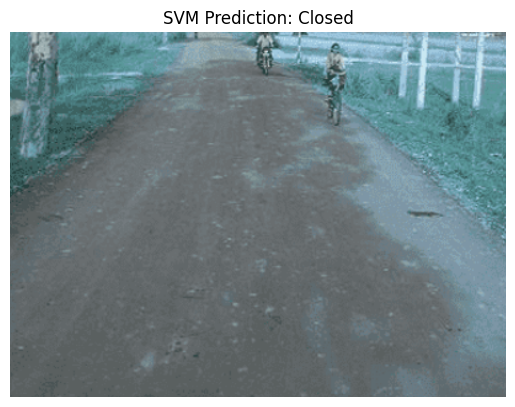

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/10
117/117 [==============================] - 32s 265ms/step - loss: 0.8663 - accuracy: 0.5836
Epoch 2/10
117/117 [==============================] - 31s 268ms/step - loss: 0.6403 - accuracy: 0.7281
Epoch 3/10
117/117 [==============================] - 33s 277ms/step - loss: 0.5476 - accuracy: 0.7596
Epoch 4/10
117/117 [==============================] - 31s 266ms/step - loss: 0.4636 - accuracy: 0.8032
Epoch 5/10
117/117 [==============================] - 31s 264ms/step - loss: 0.4050 - accuracy: 0.8347
Epoch 6/10
117/117 [==============================] - 31s 264ms/step - loss: 0.3186 - accuracy: 0.8775
Epoch 7/10
117/117 [==============================] - 32s 270ms/step - loss: 0.2538 - accuracy: 0.9036
Epoch 8/10
117/117 [==============================] - 31s 263ms/step - loss: 0.2075 - accuracy: 0.9182
Epoch 9/10
117/117 [==============================] - 31s 261ms/step - loss: 0.1466 - accuracy: 0.9467
Epoch 10/10
32/32 [==============================] - 2s 64ms/step - loss:

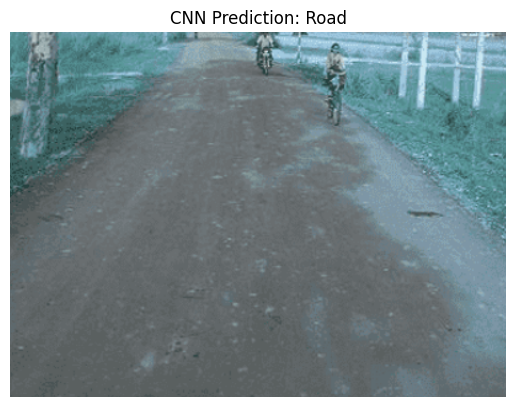

NameError: ignored

In [ ]:
# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
combined_manhole_recognition(image_path)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


32/32 [==============================] - 3s 84ms/step - loss: 0.7376 - accuracy: 0.7039
Test Loss: 0.7375730276107788
Test Accuracy (CNN): 70.38883566856384 %
1/1 [==============================] - 0s 121ms/step


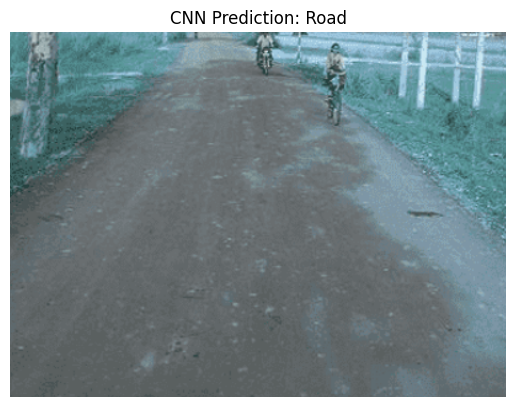

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<ipython-input-2-4194072ccc71>:60: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


Test Accuracy (SVM): 56.33100697906281 %


<ipython-input-2-4194072ccc71>:60: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),


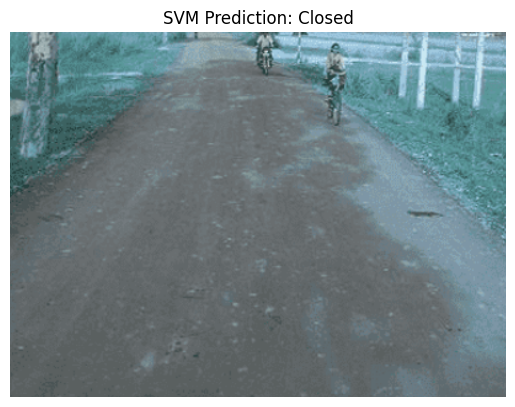

In [ ]:
#CNN and SVM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from skimage import data, color, feature
from skimage.feature import hog
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# Function to load data from different classes
def load_data(manhole, tipo):
    label = []
    arr = []
    strr = "/content/drive/MyDrive/Manhole detection/Man_hole_DB/" + manhole + "/" + tipo + "/*"
    for file_ in glob.glob(strr):
        img = cv2.imread(file_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        arr.append(img)
        label.append(manhole)
    return arr, label

# Function to load the whole dataset
def whole_train_data(tipo):
    closed_data, closed_label = load_data('Closed', tipo)
    open_data, open_label = load_data('Open', tipo)
    road_data, road_label = load_data('Road', tipo)
    data = np.concatenate((closed_data, open_data, road_data))
    labels = np.concatenate((closed_label, open_label, road_label))
    return data, labels

# Function for preprocessing the images
def preprocessing(arr):
    arr_prep = []
    for i in range(arr.shape[0]):
        img = cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        img = resize(img, (72, 72), anti_aliasing=True)
        arr_prep.append(img)
    return arr_prep

# Function to display the image with a given label
def showImg(img, name):
    plt.axis("off")
    plt.title(name)
    plt.imshow(img)
    plt.show()

# Function to extract HOG features from the image
def ExtractHOG(img):
    ftr, _ = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=True, multichannel=False,channel_axis=-1)
    return ftr

# Function to create the CNN model
def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

# Function to train the CNN model
def train_cnn():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    input_shape = (72, 72, 1)
    model = create_model(input_shape)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    label_encoder = LabelEncoder()
    labels_train_encoded = label_encoder.fit_transform(labels_train)
    labels_test_encoded = label_encoder.transform(labels_test)

    labels_train_one_hot = tf.keras.utils.to_categorical(labels_train_encoded)
    labels_test_one_hot = tf.keras.utils.to_categorical(labels_test_encoded)

    model.fit(data_train_p, labels_train_one_hot, epochs=1, batch_size=32)

    test_loss, test_acc = model.evaluate(data_test_p, labels_test_one_hot)
    print('Test Loss:', test_loss)
    print('Test Accuracy (CNN):', test_acc * 100, "%")

    return model, label_encoder

# Function to extract HOG features and train the SVM model
def train_svm():
    data_train, labels_train = whole_train_data('Train')
    data_test, labels_test = whole_train_data('Test')

    data_train_p = np.array(preprocessing(data_train))
    data_test_p = np.array(preprocessing(data_test))

    data_train_ftr = [ExtractHOG(img) for img in data_train_p]
    data_test_ftr = [ExtractHOG(img) for img in data_test_p]

    svm_clf = SVC(kernel='linear')
    svm_clf.fit(data_train_ftr, labels_train)

    y_pred = svm_clf.predict(data_test_ftr)
    accuracy = accuracy_score(labels_test, y_pred)
    print('Test Accuracy (SVM):', accuracy * 100, "%")

    return svm_clf

# Function to combine CNN and SVM for manhole recognition
def combined_manhole_recognition(image_path):
    # Train CNN and get the model and label encoder
    cnn_model, label_encoder = train_cnn()

    # Load and preprocess the image
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (72, 72), interpolation=cv2.INTER_AREA)
    img_input = np.expand_dims(np.expand_dims(img_resized, axis=0), axis=-1)

    # Make predictions using CNN
    predicted_labels_cnn = cnn_model.predict(img_input)
    predicted_label_cnn = np.argmax(predicted_labels_cnn)
    predicted_manhole_cnn = label_encoder.inverse_transform([predicted_label_cnn])[0]
    showImg(img, "CNN Prediction: " + predicted_manhole_cnn)

    # Train SVM and get the model
    svm_clf = train_svm()

    # Extract HOG features for the input image
    img_ftr = ExtractHOG(img_resized)

    # Make predictions using SVM
    predicted_label_svm = svm_clf.predict([img_ftr])
    predicted_manhole_svm = predicted_label_svm[0]
    showImg(img, "SVM Prediction: " + predicted_manhole_svm)

# Path to the image for combined manhole recognition
image_path = "/content/drive/MyDrive/Manhole detection/notebooks/Screenshot 2023-07-17 113414.png"
combined_manhole_recognition(image_path)
